# White Wine Quality Classification

Predict human wine taste preferences that is based on easily available analytical tests at the certification step. Dataset used here is related to white Vinho Verde wine samples is from the north of Portugal. The goal is to predict white wine quality score based on physicochemical attributes.

Such a model is useful to support the oenologist wine tasting evaluations and improve wine production. Furthermore, similar techniques can help in target marketing by modeling consumer tastes from niche markets.


### Library Imports

In [59]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.utils import resample

In [61]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score

In [62]:
# Global variables

# random seed
SEED = 1234

### Exploratory Data Analysis

In [63]:
feature_names = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 
                'free_SO2', 'total_SO2', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

In [64]:
# read the data from csv file into a data frame

df = pd.read_csv('winequality-white.csv', sep=';', header=0, names=feature_names)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fixed_acidity     4898 non-null   float64
 1   volatile_acidity  4898 non-null   float64
 2   citric_acid       4898 non-null   float64
 3   residual_sugar    4898 non-null   float64
 4   chlorides         4898 non-null   float64
 5   free_SO2          4898 non-null   float64
 6   total_SO2         4898 non-null   float64
 7   density           4898 non-null   float64
 8   pH                4898 non-null   float64
 9   sulphates         4898 non-null   float64
 10  alcohol           4898 non-null   float64
 11  quality           4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [66]:
df.drop_duplicates()
df.shape

(4898, 12)

There were no duplicates in the data set.

In [67]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [68]:
# class distribution for the classification label (target variable): 'quality'
df.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

Classes are highly imbalanced. Seven class labels are ordered 4-9 (bad to good quality). This issue must be addressed.

In [69]:
df.var()

fixed_acidity          0.712114
volatile_acidity       0.010160
citric_acid            0.014646
residual_sugar        25.725770
chlorides              0.000477
free_SO2             289.242720
total_SO2           1806.085491
density                0.000009
pH                     0.022801
sulphates              0.013025
alcohol                1.514427
quality                0.784356
dtype: float64

Different features have vastly different variances. chlorides, density have almost 0 variance, whereas, total_SO2 has very high variance of about 1806. This means: 
1. Need to drop the features with nearly 0 variance. These features don't change much for each target class, hence are not informative for classification purpose. 
2. The data must be scaled before before running the ML models, so that high variance features don't unduly dominate the model.

In [70]:
# Variance Inflation Factor to detect multicollinearity:

# For each feature calculate VIF (1 < VIF < infinity) 
# VIF = 1 - not collinear with any feature
# VIF = higher than 5 or 6 - highly collinear with one or more features

temp = pd.DataFrame()
temp["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
temp["feature"] = df.columns

print(temp)

            VIF           feature
0     93.075475     fixed_acidity
1     10.319377  volatile_acidity
2     10.007304       citric_acid
3      3.903134    residual_sugar
4      6.501454         chlorides
5      9.323343          free_SO2
6     25.009085         total_SO2
7   1063.719650           density
8    610.368109                pH
9     20.604027         sulphates
10   144.967476           alcohol
11    61.934404           quality


Almost all features show a very high degree of multicollinearity. One exception - residual_sugar. 

In [71]:
# degree of pair-wise linear relationships between numeric features
corr_matrix = df.corr()

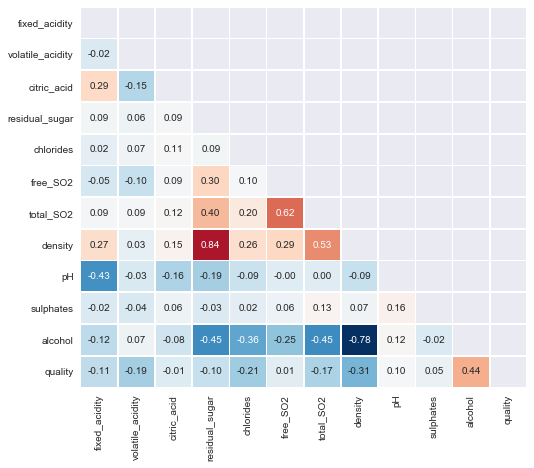

In [72]:
plt.figure(figsize=(8, 7))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, linewidths=0.7, annot=True, fmt='.2f', cmap='RdBu_r', cbar=False)
plt.show()

Density is highly correlated with residual_sugar and alcohol.

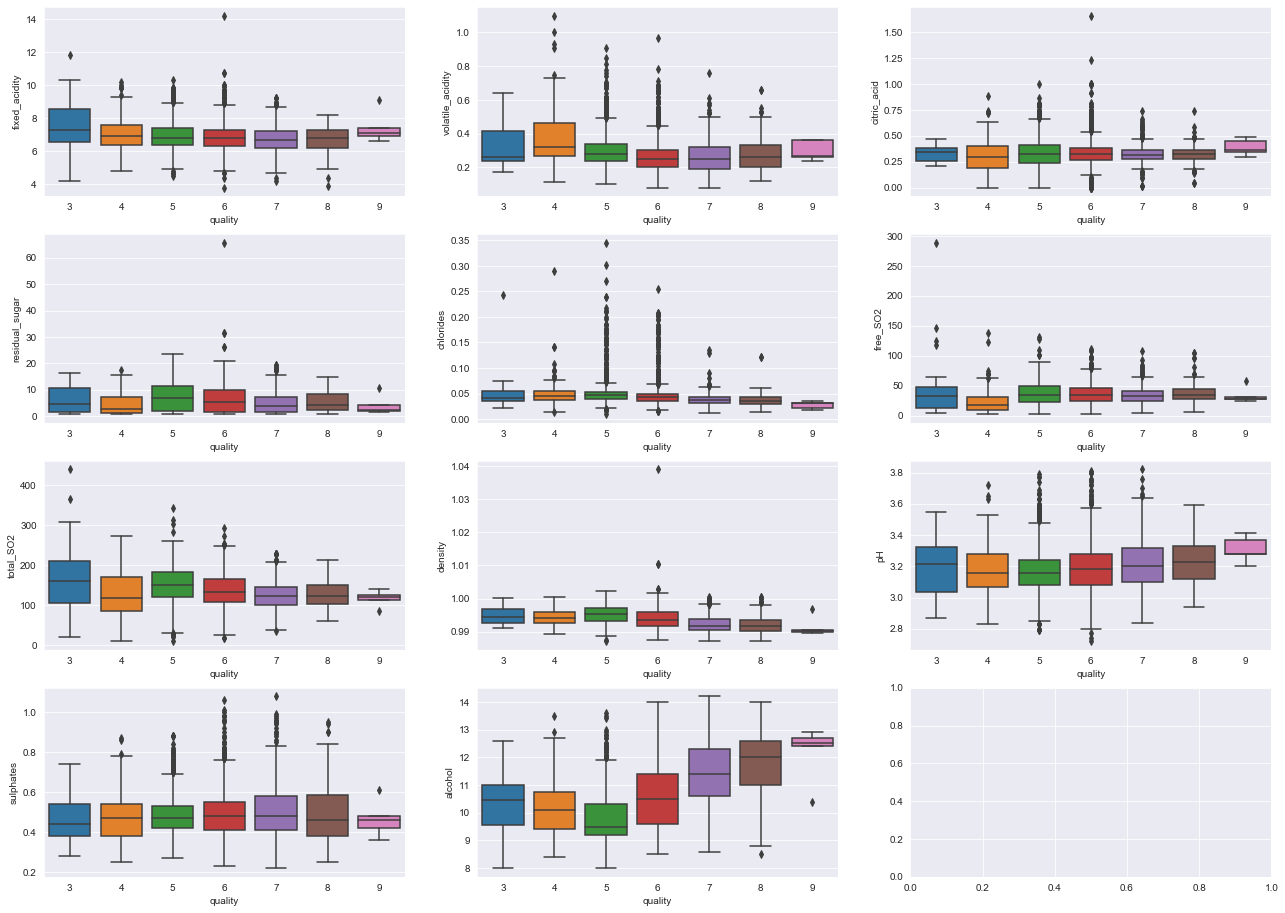

In [73]:
# distributions of numeric features by quality

fig, ax1 = plt.subplots(4,3, figsize=(22, 16))

k = 0
for i in range(4):
    for j in range(3):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='quality', y=feature_names[k], data=df, ax=ax1[i][j])
            k = k + 1    
plt.show()

residual_sugar and chlorides show relatively small separation between quality classes. These two features may have low predictive importance.

In [74]:
# possible outliers
df[(df.quality == 3) | (df.quality == 8)].groupby('quality').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,7.600000,0.33325,0.336000,6.392500,0.054300,53.325,170.600000,0.994884,3.187500,0.474500,10.345
8,6.657143,0.27740,0.326514,5.671429,0.038314,36.720,126.165714,0.992236,3.218686,0.486229,11.636


### Feature Engineering

In [75]:
# redefine quality classes: 0:low, 1:medium, 2:high in order to balance them

df.quality.replace({3:0, 4:0, 5:0, 
                    6:1, 7:1,
                    8:2, 9:2}, inplace=True)

In [76]:
df.quality.value_counts()

1    3078
0    1640
2     180
Name: quality, dtype: int64

The three new classes are still imbalanced. Further techniques must be applied to balance them.

In [77]:
# Drop chlorides because it has low predictive power and has nearly zero variance.
# Drop density because it has zero variance and high VIF.

df.drop(['chlorides', 'density'], axis=1, inplace=True)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_SO2,total_SO2,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,45.0,170.0,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,14.0,132.0,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,30.0,97.0,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,47.0,186.0,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,47.0,186.0,3.19,0.40,9.9,1


In [78]:
# check VIF again after removing the 2 features

temp = pd.DataFrame()
temp["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
temp["feature"] = df.columns

print(temp)

          VIF           feature
0   58.658825     fixed_acidity
1   10.126344  volatile_acidity
2    9.837272       citric_acid
3    3.457571    residual_sugar
4    9.245685          free_SO2
5   24.972935         total_SO2
6  151.437244                pH
7   20.574721         sulphates
8  114.276985           alcohol
9    3.572789           quality


Still there is a high degree of multicollinearity among the features. If the model accuracy is found to be low, we'll deal with multicollinearity. We'll try a few techniques:
1. use models with L1 and L2 regularization which reduce coefficients of less important features
2. fit models using PCA to reduce dimenionality and remove collinearity

### Prepare Anaytical Base Table

In [79]:
y = df['quality'].to_numpy()
y.shape

(4898,)

In [80]:
X = df.loc[:, df.columns != 'quality']
X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_SO2,total_SO2,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,45.0,170.0,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,14.0,132.0,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,30.0,97.0,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,47.0,186.0,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,47.0,186.0,3.19,0.40,9.9


In [81]:
X = X.to_numpy()

In [82]:
X.shape

(4898, 9)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [84]:
X_train.shape

(3918, 9)

In [85]:
X_test.shape

(980, 9)

In [86]:
y_train.shape

(3918,)

### Algorithm Selection

#### Get baseline score of several models

In [87]:
# create pipeline dictionary for all models (with default model parameters, unless otherwise specified.)

pipelines = {'rf': make_pipeline(StandardScaler(), 
                                RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED)),
            
             'gbc': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=SEED)),
             
             'svc': make_pipeline(StandardScaler(), 
                    SVC(probability=True, decision_function_shape='ovo', random_state=SEED)),
             
             'knn': make_pipeline(StandardScaler(), KNeighborsClassifier())
            }

In [88]:
# ROC AUC is a better metric (than accuracy) for imbalanced classes
# multi-class scheme = 'One-vs-One' because it is insensitive to class imbalance 
baseline_auc = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
    baseline_auc[name] = auc


In [89]:
print("Baseline Test AUC scores:\n", baseline_auc)

Baseline Test AUC scores:
 {'rf': 0.8528220558517815, 'gbc': 0.7821001830148172, 'svc': 0.7918091887222984, 'knn': 0.7387255888589731}


#### Fix class imbalance and see how the baseline models perform

In [90]:
# Randomly upsample minority classes

# Separate majority and minority classes (0 and 2 are minority, 1 is majority)
df_majority = df[df.quality==1]
df_minority0 = df[df.quality==0]
df_minority2 = df[df.quality==2]
 
# Upsample minority class
df_minority0_upsampled = resample(df_minority0, 
                                 replace=True,     # sample with replacement
                                 n_samples=3078,    # to match majority class
                                 random_state=SEED) # reproducible results

df_minority2_upsampled = resample(df_minority2, 
                                 replace=True,     # sample with replacement
                                 n_samples=3078,    # to match majority class
                                 random_state=SEED) # reproducible results

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority0_upsampled, df_minority2_upsampled])
 
# Display new class counts
df_upsampled.quality.value_counts()

2    3078
1    3078
0    3078
Name: quality, dtype: int64

In [91]:
y = df_upsampled['quality'].to_numpy()
y.shape

(9234,)

In [92]:
X = df_upsampled.loc[:, df_upsampled.columns != 'quality']

In [93]:
X = X.to_numpy()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [95]:
print(X_train.shape, X_test.shape)

(6463, 9) (2771, 9)


In [96]:
# fit the same models to the balanced training data set and calculate AUC on test data set
balanced_auc = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
    balanced_auc[name] = auc


In [97]:
print("Baseline Test AUC with Balanced Data Set:\n", balanced_auc)

Baseline Test AUC with Balanced Data Set:
 {'rf': 0.9896422374748565, 'gbc': 0.9144142475144409, 'svc': 0.8942969900158725, 'knn': 0.9309037768586235}


All baseline AUC scores imporoved significantly with balanced classes. Random Forest and K-Nearest Neighbors classifiers have the highest AUC.

Given the very high AUC scores, it appears that multicollinearity of the features is not adversely affecting the model performance. Therefore, we will not pursue any remeditaion measures at this point.

#### Select the best model and parameters using cross-validation

In [98]:
# create a new pipeline dictionary for the models with the best baseline scores

pipelines = {'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=SEED)),
             'knn': make_pipeline(StandardScaler(), KNeighborsClassifier())
            }

In [99]:
rf_hyperparameters = {'randomforestclassifier__n_estimators': [100, 200],
                      'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]}

In [100]:
knn_hyperparameters = {'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]}

In [101]:
# create hypermarameter dictionary

hyperparameters = {'rf': rf_hyperparameters,
                   'knn': knn_hyperparameters
                  }

In [102]:
# find the best parameters using cross-validation and fit the best models to training data set

fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    
    print('{} CV on training data set complete.'.format(name))

rf CV on training data set complete.
knn CV on training data set complete.


In [103]:
# calculate predicted probabilities and AUC score on test data set

for name, model in fitted_models.items():
    y_prob = model.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_prob, multi_class='ovo')
    print(name, 'ROC-AUC: ', auc)

rf ROC-AUC:  0.9896786622973531
knn ROC-AUC:  0.9343801619177023


In [104]:
fitted_models['rf'].best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 200}

In [105]:
print('RandomForestClassifier yields the best results.\nROC-AUC cross-validation score: 98.96%')

RandomForestClassifier yields the best results.
ROC-AUC cross-validation score: 98.96%


#### Find out which features are important for predicting wine quality

In [106]:
importances = fitted_models['rf'].best_estimator_.named_steps['randomforestclassifier'].feature_importances_
print(importances)

[0.08864456 0.11306702 0.0883321  0.09718158 0.10402518 0.10869005
 0.09262728 0.08772616 0.21970608]


In [107]:
# sort indices of the importance scores array in ascending order
indices = np.argsort(importances)[::-1]
print(indices)

[8 1 5 4 3 6 0 2 7]


In [108]:
print("Feature ranking:\n")

for f in range(X.shape[1]):
    print("%s feature %d (%f)" % (df.columns[f], indices[f], importances[indices[f]]))

Feature ranking:

fixed_acidity feature 8 (0.219706)
volatile_acidity feature 1 (0.113067)
citric_acid feature 5 (0.108690)
residual_sugar feature 4 (0.104025)
free_SO2 feature 3 (0.097182)
total_SO2 feature 6 (0.092627)
pH feature 0 (0.088645)
sulphates feature 2 (0.088332)
alcohol feature 7 (0.087726)


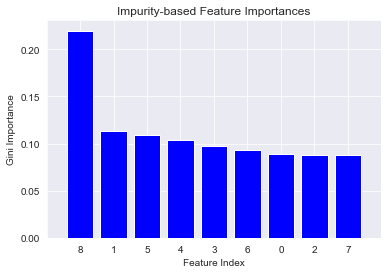

In [109]:
# Plot the impurity-based feature importances for the Random Forest classifier

plt.figure()
plt.title("Impurity-based Feature Importances")

plt.bar(range(X.shape[1]), importances[indices], color="blue", align="center")

plt.xlabel("Feature Index")
plt.ylabel("Gini Importance")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Fixed acidity is the single most important feature for predicting wine quality. Rest of the features are relatively less important, however, none is completely ineffectual. Interestingly, percentage of alcohol in the wine is the least informative feature of the wine quality. (Note that feature importance is model-specific. It does not imply intrinsic ability of the feature as good predictor of the wine quality.)